<a href="https://colab.research.google.com/github/KevinHern/SemProProject1/blob/master/Dermatology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

# Dataset

## Extracting

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/KevinHern/SemProProject1/master/dermatology.csv')

## Getting to know the Dataset

In [40]:
df.head()

,2,2.1,0,3,0.1,0.2,0.3,0.4,1,0.5,0.6,0.7,0.8,0.9,0.10,3.1,2.2,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,3.2,0.21,0.22,0.23,1.1,0.24,55,2.3
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,2


In [0]:
df.columns = ['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'family history, (0 or 1)', 
               'melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']
df['Classcode'] = df['Classcode'] - 1

In [42]:
df

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,"family history, (0 or 1)",melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,0
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,2
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,0
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,2
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,25,3
361,3,2,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,36,3
362,3,2,2,2,3,2,0,2,0,0,0,2,2,0,0,3,3,0,0,0,0,0,0,0,3,0,3,0,3,0,0,2,3,28,2
363,2,1,3,1,2,3,0,2,0,0,0,2,0,0,0,3,2,0,0,0,0,0,0,0,3,0,2,0,1,0,0,2,3,50,2


## Cleaning Dataset

In [43]:
temp = df[df['Age'] != '?']
temp = temp.astype(int)
meanAge = math.floor(temp['Age'].mean())
meanAge

36

In [44]:
df = df.replace('?', meanAge)
df[df['Age'] == '?']

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,"family history, (0 or 1)",melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode


In [45]:
for i in df.columns:
  df[i] = df[i].astype(int)
df.dtypes

erythema                                    int64
scaling                                     int64
definite borders                            int64
itching                                     int64
koebner phenomenon                          int64
polygonal papules                           int64
follicular papules                          int64
oral mucosal involvement                    int64
knee and elbow involvement                  int64
scalp involvement                           int64
family history, (0 or 1)                    int64
melanin incontinence                        int64
eosinophils in the infiltrate               int64
PNL infiltrate                              int64
fibrosis of the papillary dermis            int64
exocytosis                                  int64
acanthosis                                  int64
hyperkeratosis                              int64
parakeratosis                               int64
clubbing of the rete ridges                 int64


## Correlation

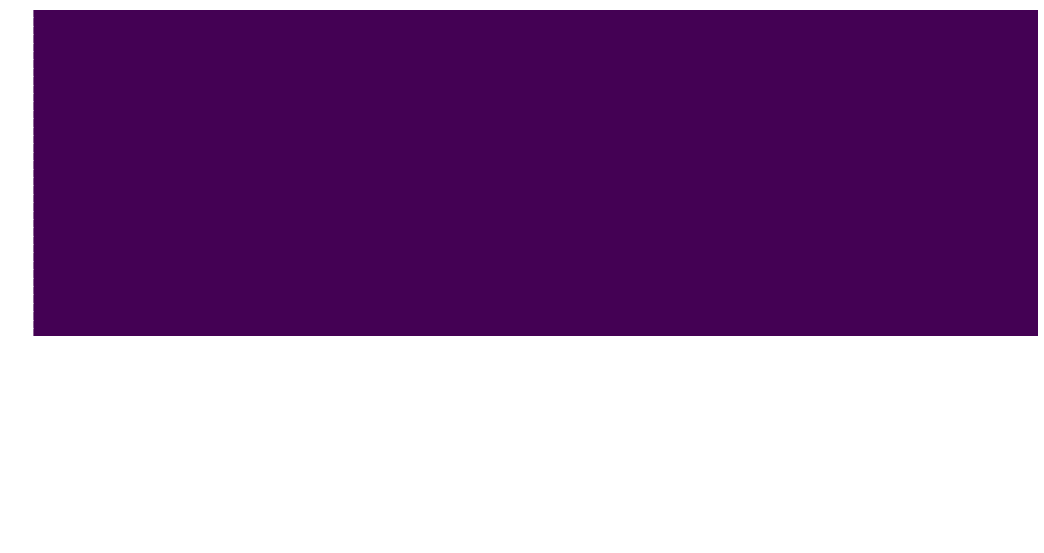

In [46]:
plt.figure(figsize=(18,6))
sns.heatmap(df.isnull(), yticklabels=True, cbar=False, cmap='viridis', xticklabels=True)

## Splitting

Particionamos el dataset en:

*   75% training
*   15% test
*   10% validation

In [47]:
train_split = df.sample(frac = 0.75,random_state=42)
test_split = df.drop(train_split.index)

train_split.shape, test_split.shape

((274, 35), (91, 35))

### Getting Train Labels and Train data

In [48]:
train_labels = train_split['Classcode']
train_data = train_split
train_data = train_data.drop(columns=['Classcode'])

train_labels.shape, train_data.shape

((274,), (274, 34))

### Getting Test Labels and Test Labels

In [52]:
test_labels = test_split['Classcode']
test_data = test_split
test_data = test_data.drop(columns=['Classcode'])

test_labels.shape, test_data.shape

((91,), (91, 34))

# Models

Metodología:
Queremos ver qué modelo tiene mejor Accuracy utilizando diversos conjuntos de features
Se realizan 4 modelos:

1.   Un modelo que utiliza todos los features del dataset.
2.   Un modelo que utiliza únicamente los features clínicos
3.   Un modelo que utiliza únicamente los datos histopatológicos
4.   Un modelo que utiliza los features más importantes extraídos del heatmap

El approach que se empleará para determinar qué arquitectura es la mejor continene las siguientes condiciones:

*   Los 4 modelos se someterán a los mismos datasets
*   Los 4 modelos tendrán las mismas arquitecturas para ser comparables. Las capas ocultas tendrán neuronas en potencias de 2
*   Se realizarán 4 pruebas, donde cada prueba se utilizará una arquitectura distinta.







## Model 1: 3 hidden layers

### Test 1: 2 hidden layers

In [61]:
model1 = Sequential([
  
  Dense(1024, activation='relu', input_shape=(34,)),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(6, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model1.fit(train_data,
                     train_labels,
                    epochs=5,
                    #validation_data=validation_split,
                     validation_split=0.3
                   )

#results = model1.evaluate(test_data)
classifications = model1.predict(test_data)

Train on 191 samples, validate on 83 samples
Epoch 1/5
191/191 [==============================] - 0s 2ms/sample - loss: 2.2767 - accuracy: 0.2565 - val_loss: 1.3799 - val_accuracy: 0.5783
Epoch 2/5
191/191 [==============================] - 0s 422us/sample - loss: 1.2831 - accuracy: 0.4660 - val_loss: 0.8299 - val_accuracy: 0.7349
Epoch 3/5
191/191 [==============================] - 0s 372us/sample - loss: 0.8084 - accuracy: 0.7016 - val_loss: 0.4831 - val_accuracy: 0.8675
Epoch 4/5
191/191 [==============================] - 0s 441us/sample - loss: 0.5710 - accuracy: 0.8115 - val_loss: 0.4193 - val_accuracy: 0.7831
Epoch 5/5
191/191 [==============================] - 0s 366us/sample - loss: 0.3745 - accuracy: 0.8639 - val_loss: 0.1706 - val_accuracy: 0.9518


### Test 2: 3 hidden layers

In [62]:
model1 = Sequential([
  
  Dense(1024, activation='relu', input_shape=(34,)),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(6, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model1.fit(train_data,
                     train_labels,
                    epochs=5,
                    #validation_data=validation_split,
                     validation_split=0.3
                   )

#results = model1.evaluate(test_data)
classifications = model1.predict(test_data)

Train on 191 samples, validate on 83 samples
Epoch 1/5
191/191 [==============================] - 0s 2ms/sample - loss: 1.8738 - accuracy: 0.2984 - val_loss: 1.4380 - val_accuracy: 0.3735
Epoch 2/5
191/191 [==============================] - 0s 428us/sample - loss: 1.3098 - accuracy: 0.5497 - val_loss: 0.8194 - val_accuracy: 0.7470
Epoch 3/5
191/191 [==============================] - 0s 466us/sample - loss: 0.8619 - accuracy: 0.6492 - val_loss: 0.4936 - val_accuracy: 0.9398
Epoch 4/5
191/191 [==============================] - 0s 440us/sample - loss: 0.5707 - accuracy: 0.8220 - val_loss: 0.3640 - val_accuracy: 0.9157
Epoch 5/5
191/191 [==============================] - 0s 401us/sample - loss: 0.4274 - accuracy: 0.8377 - val_loss: 0.2526 - val_accuracy: 0.9639


### Test 3: 4 hidden layers

In [63]:
model1 = Sequential([
  
  Dense(1024, activation='relu', input_shape=(34,)),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(6, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model1.fit(train_data,
                     train_labels,
                    epochs=5,
                    #validation_data=validation_split,
                     validation_split=0.3
                   )

#results = model1.evaluate(test_data)
classifications = model1.predict(test_data)

Train on 191 samples, validate on 83 samples
Epoch 1/5
191/191 [==============================] - 0s 2ms/sample - loss: 1.7727 - accuracy: 0.2251 - val_loss: 1.3616 - val_accuracy: 0.4699
Epoch 2/5
191/191 [==============================] - 0s 386us/sample - loss: 1.4854 - accuracy: 0.4346 - val_loss: 1.1632 - val_accuracy: 0.7108
Epoch 3/5
191/191 [==============================] - 0s 396us/sample - loss: 1.0885 - accuracy: 0.5916 - val_loss: 0.7230 - val_accuracy: 0.7831
Epoch 4/5
191/191 [==============================] - 0s 444us/sample - loss: 0.7051 - accuracy: 0.8063 - val_loss: 0.4212 - val_accuracy: 0.9277
Epoch 5/5
191/191 [==============================] - 0s 389us/sample - loss: 0.4508 - accuracy: 0.8429 - val_loss: 0.2481 - val_accuracy: 0.9036


### Test 4: 5 hidden layers

In [64]:
model1 = Sequential([
  
  Dense(1024, activation='relu', input_shape=(34,)),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(6, activation='softmax')
])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model1.fit(train_data,
                     train_labels,
                    epochs=5,
                    #validation_data=validation_split,
                     validation_split=0.3
                   )

#results = model1.evaluate(test_data)
classifications = model1.predict(test_data)

Train on 191 samples, validate on 83 samples
Epoch 1/5
191/191 [==============================] - 0s 3ms/sample - loss: 1.7097 - accuracy: 0.3089 - val_loss: 1.3532 - val_accuracy: 0.5060
Epoch 2/5
191/191 [==============================] - 0s 424us/sample - loss: 1.3059 - accuracy: 0.5079 - val_loss: 0.9045 - val_accuracy: 0.6867
Epoch 3/5
191/191 [==============================] - 0s 387us/sample - loss: 0.9554 - accuracy: 0.6387 - val_loss: 0.5659 - val_accuracy: 0.8916
Epoch 4/5
191/191 [==============================] - 0s 377us/sample - loss: 0.6987 - accuracy: 0.7906 - val_loss: 0.4060 - val_accuracy: 0.8916
Epoch 5/5
191/191 [==============================] - 0s 424us/sample - loss: 0.5059 - accuracy: 0.8272 - val_loss: 0.3083 - val_accuracy: 0.9759
